# Data mining the water table

Your goal is to predict the operating condition of a waterpoint for each record in the dataset. You are provided the following set of information about the waterpoints:

* `amount_tsh` - Total static head (amount water available to waterpoint)
* `date_recorded` - The date the row was entered
* `funder` - Who funded the well
* `gps_height` - Altitude of the well
* `installer` - Organization that installed the well
* `longitude` - GPS coordinate
* `latitude` - GPS coordinate
* `wpt_name` - Name of the waterpoint if there is one
* `num_private` -
* `basin` - Geographic water basin
* `subvillage` - Geographic location
* `region` - Geographic location
* `region_code` - Geographic location (coded)
* `district_code` - Geographic location (coded)
* `lga` - Geographic location
* `ward` - Geographic location
* `population` - Population around the well
* `public_meeting` - True/False
* `recorded_by` - Group entering this row of data
* `scheme_management` - Who operates the waterpoint
* `scheme_name` - Who operates the waterpoint
* `permit` - If the waterpoint is permitted
* `construction_year` - Year the waterpoint was constructed
* `extraction_type` - The kind of extraction the waterpoint uses
* `extraction_type_group` - The kind of extraction the waterpoint uses
* `extraction_type_class` - The kind of extraction the waterpoint uses
* `management` - How the waterpoint is managed
* `management_group` - How the waterpoint is managed
* `payment` - What the water costs
* `payment_type` - What the water costs
* `water_quality` - The quality of the water
* `quality_group` - The quality of the water
* `quantity` - The quantity of water
* `quantity_group` - The quantity of water
* `source` - The source of the water
* `source_type` - The source of the water
* `source_class` - The source of the water
* `waterpoint_type` - The kind of waterpoint
* `waterpoint_type_group` - The kind of waterpoint

The labels in this dataset are simple. There are three possible values:

* `functional` - the waterpoint is operational and there are no repairs needed
* `functional needs repair` - the waterpoint is operational, but needs repairs
* `non functional` - the waterpoint is not operational

Your `.csv` file that you submit would look like:

```
id,status_group
50785,functional
51630,functional
17168,functional
45559,functional
...
```

# Import and load data

In [63]:
# for seaborn distplot
def _revrt(X,m=None):
    """
    Inverse of forrt. Equivalent to Munro (1976) REVRT routine.
    """
    if m is None:
        m = len(X)
    i = int(m // 2+1)
    y = X[:i] + np.r_[0,X[i:],0]*1j
    return np.fft.irfft(y)*m

from statsmodels.nonparametric import kdetools

# replace the implementation with new method.
kdetools.revrt = _revrt

# import seaborn AFTER replacing the method. 
import seaborn as sns

In [64]:
import pandas as pd
import numpy as np

# Graphs
import matplotlib.pyplot as plt
%matplotlib inline

# Plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter

# Missing values
import missingno as msno

# ML
from sklearn.preprocessing import LabelEncoder, Imputer, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.multiclass import OneVsRestClassifier

from xgboost import XGBClassifier, plot_importance

# DL
from keras.utils import np_utils

pd.options.display.max_columns = 50

In [65]:
def my_plot_importance(booster, figsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)

In [66]:
def X_nan(X):

    # categorical
    X.wpt_name = X.wpt_name.replace('None', np.NaN)
    X.scheme_management = X.scheme_management.replace('None', np.NaN)
    X.management = X.management.replace('unknown', np.NaN)
    X.management_group = X.management_group.replace('unknown', np.NaN)
    X.payment = X.payment.replace('unknown', np.NaN)
    X.payment_type = X.payment_type.replace('unknown', np.NaN)
    X.water_quality = X.water_quality.replace('unknown', np.NaN)
    X.quality_group = X.quality_group.replace('unknown', np.NaN)
    X.quantity = X.quantity.replace('unknown', np.NaN)
    X.quantity_group = X.quantity_group.replace('unknown', np.NaN)
    X.source = X.source.replace('unknown', np.NaN)
    X.source_class = X.source_class.replace('unknown', np.NaN)
    X.funder = X.funder.replace('0', np.NaN)
    X.installer = X.installer.replace('0', np.NaN)
    #subvillage?
    #scheme_name?
    
    # continuous to categorical
    catcols = ['region_code','district_code']
    for col in catcols:
        X[col] = X[col].astype('object')
        
    # continuous
    X.construction_year = X.construction_year.replace(0, np.NaN)
    X.latitude = X.latitude.replace(0, np.NaN)
    X.longitude = X.longitude.replace(0, np.NaN)
    X.gps_height = X.gps_height.replace(0, np.NaN)
    X.population = X.population.replace(0, np.NaN)
    X.population = X.population.replace(1, np.NaN)
    #X.amount_tsh = X.amount_tsh.replace(0, np.NaN) ### should not get rid of those

    return X

In [67]:
# from https://www.kaggle.com/nikunjm88/carefully-dealing-with-missing-values

def fillna_knn(df, base, target, fraction = 1, threshold = 10, n_neighbors = 5):
    assert isinstance(base, list) or isinstance(base , np.ndarray) and isinstance(target, str) 
    whole = [ target ] + base
    
    miss = df[target].isnull()
    notmiss = ~miss 
    nummiss = miss.sum()
    
    enc = OneHotEncoder()
    X_target = df.loc[ notmiss, whole ].sample( frac = fraction )
    
    enc.fit( X_target[ target ].unique().reshape( (-1,1) ) )
    
    Y = enc.transform( X_target[ target ].values.reshape((-1,1)) ).toarray()
    X = X_target[ base  ]
    
    print('fitting')
    n_neighbors = n_neighbors
    clf = neighbors.KNeighborsClassifier( n_neighbors, weights = 'uniform')
    clf.fit( X, Y )
    
    print('the shape of active features: ' ,enc.active_features_.shape)

    print('predicting')
    Z = clf.predict(df.loc[miss, base])
    
    numunperdicted = Z[:,0].sum()
    if numunperdicted / nummiss *100 < threshold :
        print( 'writing result to df' )    
        df.loc[ miss, target ]  = np.dot( Z , enc.active_features_ )
        print( 'num of unperdictable data: ', numunperdicted )
        return enc
    else:
        print( 'out of threshold: {}% > {}%'.format( numunperdicted / nummiss *100 , threshold ) )

#function to deal with variables that are actually string/categories
def zoningcode2int( df, target ):
    storenull = df[ target ].isnull()
    enc = LabelEncoder( )
    df[ target ] = df[ target ].astype( str )

    print('fit and transform')
    df[ target ]= enc.fit_transform( df[ target ].values )
    print( 'num of categories: ', enc.classes_.shape  )
    df.loc[ storenull, target ] = np.nan
    print('recover the nan value')
    return enc

In [68]:
def fillna_linreg(df, base, target):
    
    linreg = LinearRegression()
    
    whole = [target] + base # get list of all columns
    miss = df[target].isnull() # boolean evaluation of missing rows in the target to predict
    notmiss = ~miss # number of missing values
    nummiss = miss.sum() 
    
    X_target = df.loc[notmiss, whole] # get training dataframe
    Y = X_target[target] # split training dataframe Y
    X = X_target[base] # split training dataframe X

    linreg.fit(X, Y) # fit the model

    Z = linreg.predict(df.loc[miss, base])

    df.loc[ miss, target ] = Z
    
    return None

In [69]:
random_seed = 42

In [70]:
X = pd.read_csv('train_feats.csv')

In [71]:
y = pd.read_csv('train_labels.csv').pop('status_group')

<hr>

# Missing values

## Continuous variables

Continuous could potentially have the following missing values:
* `amount_tsh`: The distribution of the amount of water available to waterpoint (total static head) is very skewed towards zero. However, at this point cannot be sure if that represents a missing value, or if there is just no water available...
* `gps_height`: This represents the altitude of the well, and once again there are a lot of zeros in the distribution. Once again it is not sure whether this represents missing data masked as zeros or actual zero altitude.
* `longitude` & `latitude`: Distribution looks ok, but there are still a few zeros falling slightly outside of the range - are they missing values or actual zeros?
* `population`: is the population around the well really 0? There are also a few other small values such as 1, 2, 3, 4, ... etc.
* `construction_year`: suspecting that 0 values represent missing values - There are 20709 instances in `construction_year` with value 0.

### `longitude`, `latitude` and `gps_height`

No handles with labels found to put in legend.


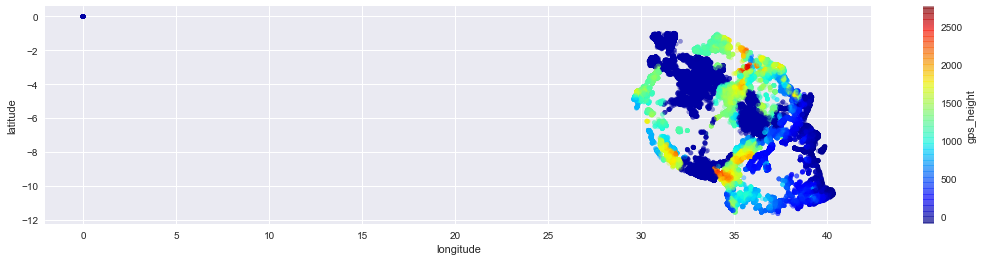

In [72]:
X.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(18.5,4),
          c="gps_height", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)
plt.legend()

There seems to be outliers where both latitude and longitude are zero, and they don't represent any data geographic coordinates within Tanzania, so we can safely discard those.

The elevation in Tanzania looks quite different than seen on the graph above. While the elevation in the east is indeed very low, elevations in the center and towards the west should not be 0. It seems that we have a lot of missing data in this column.

## Categorical variables

Unsure if missing values exist:

* `funder`: Has values like 0 in there... missing value?
* `installer`: Has values like 0 in there... missing value?
* `subvillage`: Has values like M, 1, and I in there... missing value?
* `scheme_name`: Has values like K, M, I, N, S in there... missing value?

## Get proper missing values

In [73]:
X_nan = X_nan(X)

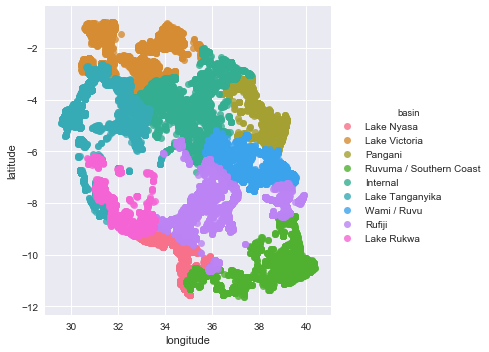

In [74]:
sns.lmplot('longitude', 'latitude', data=X_nan, hue='basin', fit_reg=False)

## Visualize NaNs

The `msno.matrix` nullity matrix is a data-dense display which lets you quickly visually pick out patterns in data completion. The sparkline at right summarizes the general shape of the data completeness and points out the maximum and minimum rows.

This visualization will comfortably accommodate up to 50 labelled variables. Past that range labels begin to overlap or become unreadable, and by default large displays omit them.

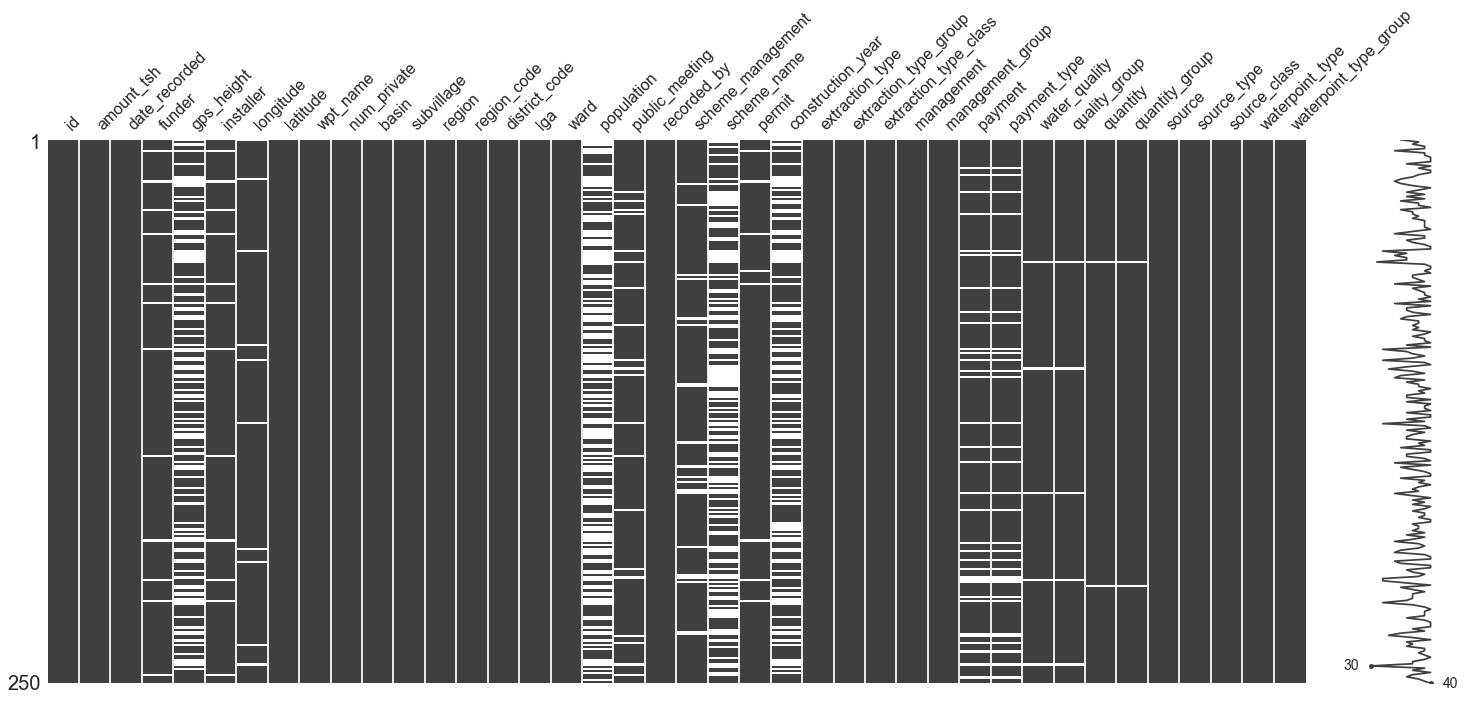

In [75]:
msno.matrix(X_nan.sample(250))

`msno.bar` is a simple visualization of nullity by column:

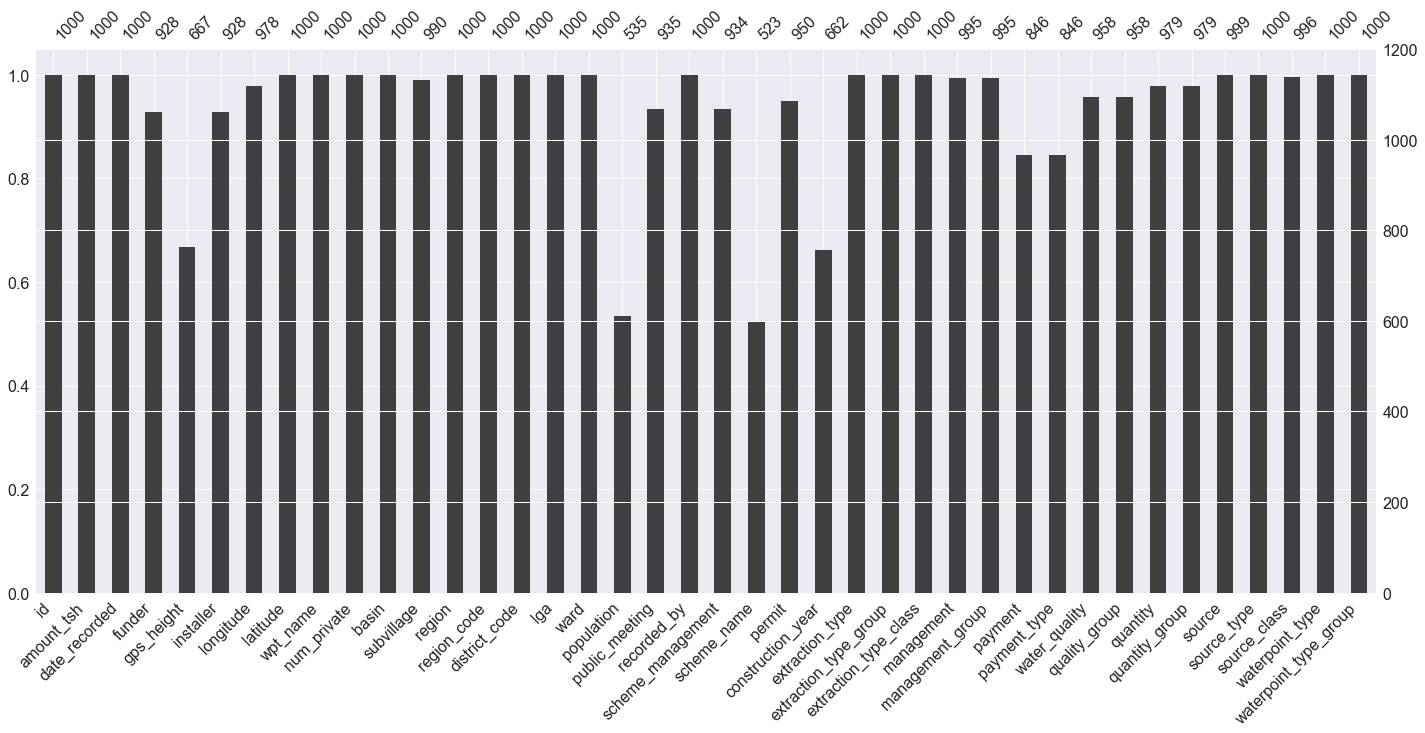

In [76]:
msno.bar(X_nan.sample(1000))

The `missingno` correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another. Values which are often missing together can help you solve the problem.

Nullity correlation ranges from
* `-1` (if one variable appears the other definitely does not) to 
* `0` (variables appearing or not appearing have no effect on one another) to
* `1` (if one variable appears the other definitely also does).

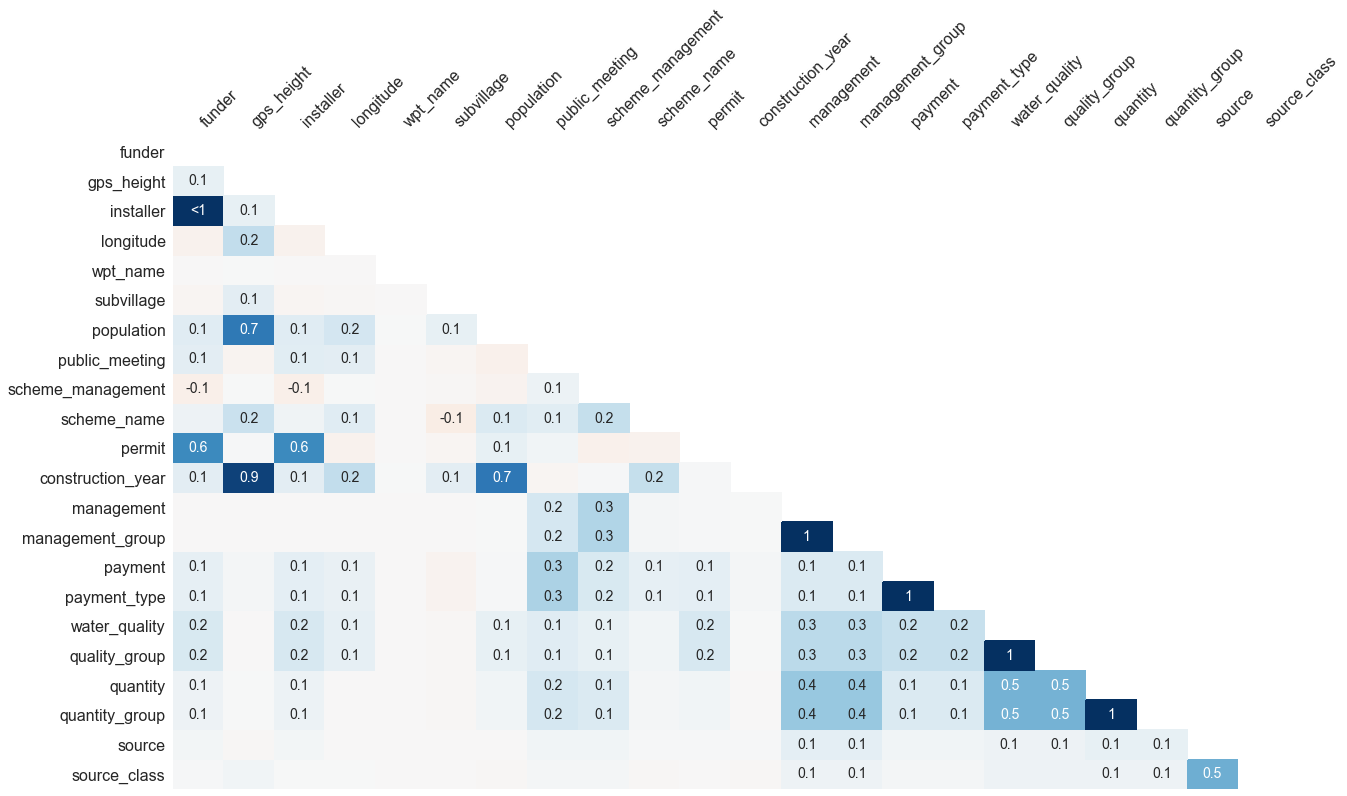

In [77]:
msno.heatmap(X_nan)

The `dendrogram` allows you to more fully correlate variable completion, revealing trends deeper than the pairwise ones visible in the correlation heatmap:

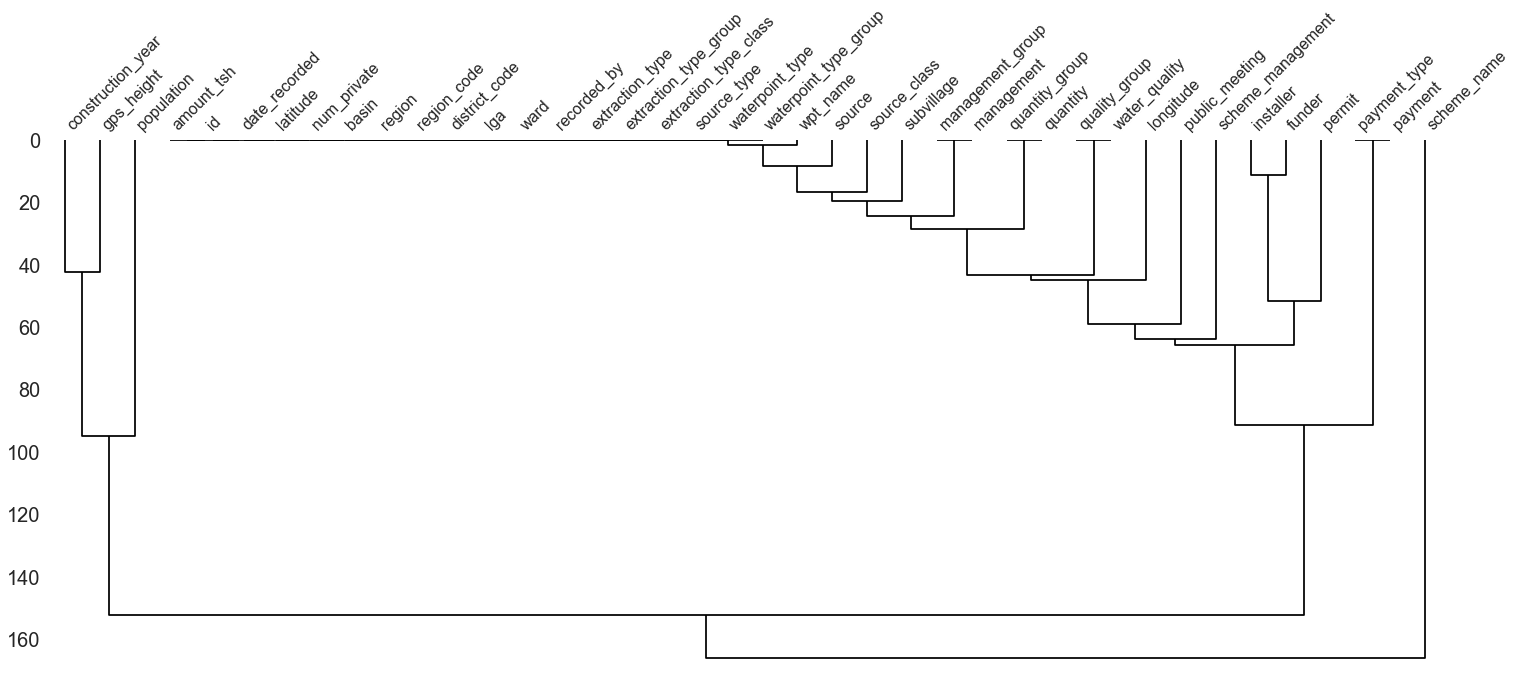

In [78]:
msno.dendrogram(X_nan)

At each step of the tree the variables are split up based on which combination minimizes the distance of the remaining clusters. The more monotone the set of variables, the closer their total distance is to zero, and the closer their average distance (the y-axis) is to zero.

To interpret this graph, read it from a top-down perspective. Cluster leaves which linked together at a distance of zero fully predict one another's presence—one variable might always be empty when another is filled, or they might always both be filled or both empty, and so on. In this specific example the dendrogram glues together the variables which are required and therefore present in every record.

Cluster leaves which split close to zero, but not at it, predict one another very well, but still imperfectly. If your own interpretation of the dataset is that these columns actually are or ought to be match each other in nullity (for example, as `CONTRIBUTING FACTOR VEHICLE 2` and `VEHICLE TYPE CODE 2` ought to), then the height of the cluster leaf tells you, in absolute terms, how often the records are "mismatched" or incorrectly filed—that is, how many values you would have to fill in or drop, if you are so inclined.

In [79]:
# how many total missing values do we have?
total_cells = np.product(X_nan.shape)
total_missing = X_nan.isnull().sum().sum()

# percent of data that is missing
(total_missing/total_cells) * 100

5.981734006734007

* *Randomly missing data*: If data is missing totally at random (whether a value is missing does not depend on any of the feature values of that item), then imputation can be appropriate. 
* *Nonrandomly missing data*: In contrast, if the chance for data to go missing for some object depends on the value of the features of that object, then you have a bigger problem. In that case imputation can create bias -- as can any other method. Your best hope is to understand in greater depth the random process that causes data to be missing and the probability distribution (probability that data goes missing, as a function of feature values), and try to design a procedure that is appropriate for that process.

<hr>

# Handling missing values

In [80]:
X_clean = X_nan

In [81]:
clean_cols = X_clean.columns[-X_clean.isnull().any()].tolist()

In [82]:
#clean_cols_num = X_clean[X_clean.columns[-X_clean.isnull().any()].tolist()].dtypes.pipe(lambda X_use: X_use[X_use=='float']).index.tolist()

Let's first take a look at some correlations, to better decide which features can be used in a linear regression predictor.

In [83]:
temp = X_clean

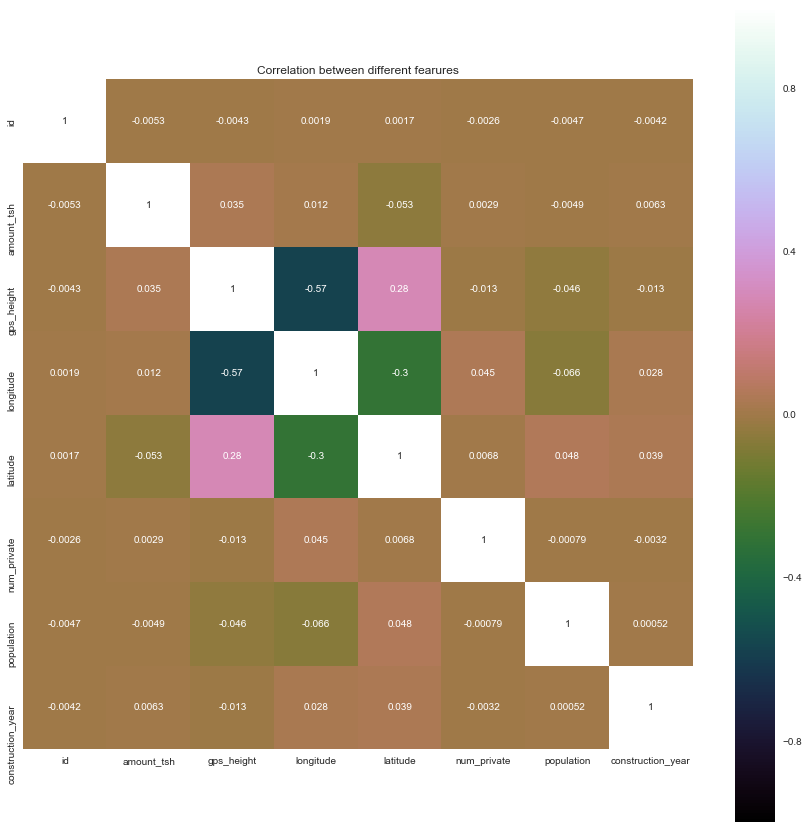

In [84]:
#Another type of correlation matrix 
correlation = temp.corr()
plt.figure(figsize=(15,15))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

plt.title('Correlation between different fearures')
plt.show()

It seems that`latitude` and `longitude`, as well as `longitude` and `gps_height`, and also `latitude` and `gps_height` are somewhat negatively correlated.

### Predicting the missing values

Using the features which do not have missing values, we can predict the nulls with the help of a machine learning algorithm. This method may result in better accuracy, unless a missing value is expected to have a very high variance. We will be using linear regression to replace the nulls in the feature ‘age’, using other available features. One can experiment with different algorithms and check which gives the best accuracy instead of sticking to a single algorithm.

Pros:
* Imputing the missing variable is an improvement as long as the bias from the same is smaller than the omitted variable bias
* Yields unbiased estimates of the model parameters

Cons:
* Bias also arises when an incomplete conditioning set is used for a categorical variable
* Considered only as a proxy for the true values

### Continuous: Replacing With Mean/Median/Mode

This strategy can be applied on a feature which has numeric data like the age of a person or the ticket fare. We can calculate the mean, median or mode of the feature and replace it with the missing values. This is an approximation which can add variance to the data set. But the loss of the data can be negated by this method which yields better results compared to removal of rows and columns. Replacing with the above three approximations are a statistical approach of handling the missing values. This method is also called as leaking the data while training. Another way is to approximate it with the deviation of neighbouring values. This works better if the data is linear.  

Pros:
* This is a better approach when the data size is small
* It can prevent data loss which results in removal of the rows and columns

Cons:
* Imputing the approximations add variance and bias
* Works poorly compared to other multiple-imputations method

* `construction_year`: suspecting that 0 values represent missing values

### Categorical: Assigning An Unique Category

A categorical feature will have a definite number of possibilities, such as gender, for example. Since they have a definite number of classes, we can assign another class for the missing values. Here, the features Cabin and Embarked have missing values which can be replaced with a new category, say, U for ‘unknown’. This strategy will add more information into the dataset which will result in the change of variance. Since they are categorical, we need to find one hot encoding to convert it to a numeric form for the algorithm to understand it. Let us look at how it can be done in Python:

Pros:
* Less possibilities with one extra category, resulting in low variance after one hot encoding — since it is categorical
* Negates the loss of data by adding an unique category

Cons:
* Adds less variance
* Adds another feature to the model while encoding, which may result in poor performance

In [85]:
def clean(X_clean):
    try:
        # get clean cols
        clean_cols_num = X_clean[X_clean.columns[-X_clean.isnull().any()].tolist()].dtypes.pipe(lambda X_use: X_use[X_use=='float']).index.tolist()
        # predict longitude
        fillna_linreg(df = X_clean, base = clean_cols_num, target = 'longitude')
        # predict gps_height
        fillna_linreg(df = X_clean, base = ['latitude', 'longitude'], target = 'gps_height')
        # predict population
        fillna_linreg(df = X_clean, base = ['latitude', 'longitude', 'gps_height'], target = 'population')
        # get clean cols
        clean_cols_num = X_clean[X_clean.columns[-X_clean.isnull().any()].tolist()].dtypes.pipe(lambda X_use: X_use[X_use=='float']).index.tolist()
        # predict construction year
        fillna_linreg(df = X_clean, base = clean_cols_num, target = 'construction_year')
        miss_cols_cat = X_clean[X_clean[X_clean.columns[X_clean.isnull().any()]].isnull().sum().sort_values()
                                .index.tolist()].dtypes.pipe(lambda X_use: X_use[X_use=='object']).index.tolist()
        for col in miss_cols_cat:
            X[col] = X[col].fillna("Unknown")
    except Exception as err:
        print('No missing values.')
        print(err)

In [86]:
clean(X_clean)

### Deleting rows

This method commonly used to handle the null values. Here, we either delete a particular row if it has a null value for a particular feature and a particular column if it has more than 70-75% of missing values. This method is advised only when there are enough samples in the data set. One has to make sure that after we have deleted the data, there is no addition of bias. Removing the data will lead to loss of information which will not give the expected results while predicting the output.

Pros:
* Complete removal of data with missing values results in robust and highly accurate model
* Deleting a particular row or a column with no specific information is better, since it does not have a high weightage

Cons:
* Loss of information and data
* Works poorly if the percentage of missing values is high (say 30%), compared to the whole dataset

How much data would we lose if we drop all the rows with missing data?

<hr>

In [87]:
drop_cols = X_clean.columns[X_clean.isnull().any()].tolist()

In [88]:
X_drop = X_clean.drop(drop_cols, axis=1)

In [89]:
# remove all rows with at least one missing value
y_rows_dropped = y.drop(y.index[X_drop.isnull().any(axis=1)[X_drop.isnull().any(axis=1) == True].index])
X_rows_dropped = X_drop.dropna()

# just how much data did we lose?
print("Rows in original dataset: %d \n" % X_drop.shape[0])
print("Rows with na's dropped: %d" % X_rows_dropped.shape[0])

Rows in original dataset: 59400 

Rows with na's dropped: 59400


Let's see how much data we will lose if we remove all the *columns* that have at least one missing value:

In [90]:
# remove all columns with at least one missing value
X_columns_dropped = X_drop.dropna(axis=1)

# just how much data did we lose?
print("Columns in original dataset: %d \n" % X_drop.shape[1])
print("Columns with na's dropped: %d" % X_columns_dropped.shape[1])

Columns in original dataset: 40 

Columns with na's dropped: 40


# Machine Learning

In [91]:
X_use = X_clean
y_use = y

In [92]:
def encode_X(X_use):

    #GET LIST OF COLUMNS TO ENCODE
    cols_to_enc = list(X_use.select_dtypes(include=['category', 'object']))

    for feature in cols_to_enc:
        try:
            #CONVERT VALUE TO STRING (TO AVOID UNORDERED TYPE ERRORS)
            X_use[feature] = X_use[feature].astype(str)
        except Exception as err:
            print('cannot convert: %s' %  feature)
            print(err)

    encoder = LabelEncoder()
    cat_colums = X_use.dtypes.pipe(lambda X_use: X_use[X_use=='object']).index
    for col in cat_colums:
        X_use[col] = encoder.fit_transform(X_use[col])

    encoder = LabelEncoder()
    cat_colums = X_use.dtypes.pipe(lambda X_use: X_use[X_use=='category']).index
    for col in cat_colums:
        X_use[col] = encoder.fit_transform(X_use[col])
    
    return X_use

In [93]:
def encode_y(y):

    # encode class values as integers
    encoder = LabelEncoder()
    encoder.fit(y)
    y_encoded = encoder.transform(y)
    # convert integers to dummy variables (i.e. one hot encoded)
    y_dummy = np_utils.to_categorical(y_encoded)
    
    return y_dummy

In [94]:
X_use = encode_X(X_use)
y_dummy = encode_y(y)

Create `dummy_y` by encoding categorical string labels to...

* `functional` = 0
* `functional needs repair` = 1
* `non functional` = 2

...and afterwards one-hot encoding.

In [95]:
pd.DataFrame(y_dummy).head()

,0,1,2
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,0.0,0.0,1.0
4,1.0,0.0,0.0


Features that are not informative:
* `id`
* `date_recorded` - The date the row was entered
* `num_private` -
* `wpt_name` - Name of the waterpoint if there is one
* `recorded_by` - Group entering this row of data

In [96]:
X_use = X_use.drop(['id', 'date_recorded', 'num_private', 'wpt_name', 'recorded_by'], axis=1)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X_use, y_use, test_size=0.2, random_state=random_seed)

In [98]:
# normalize the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### XGBoost

In [99]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

A total number of combinations for the set of parameters above is a product of options for each parameter (3 x 5 x 3 x 3 x 3 = 405). It also needs to be multiplied by 5 to calculate a total number of data-fitting runs as we will be doing 5-fold cross-validation. That gets to be a large number in a hurry if you are using many parameters and lots of options, which is why brute-force grid search takes a long time.

In [100]:
xgb = XGBClassifier(max_depth=10, learning_rate=0.1, n_estimators=100, seed=10)
xgb_fit = xgb.fit(X_train, y_train)
xgb_pred = xgb_fit.predict(X_test)

/Users/Claudi/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



In [101]:
accuracy_score(y_test,xgb_pred)
#0.8116 not scaled
#0.8103 scaled

0.8116161616161616

In [102]:
print('Misclassified samples: %d' % (y_test != xgb_pred).sum())

Misclassified samples: 2238


In [103]:
print(classification_report(y_test,xgb_pred))

                         precision    recall  f1-score   support

             functional       0.79      0.92      0.85      6457
functional needs repair       0.63      0.28      0.39       851
         non functional       0.87      0.76      0.81      4572

            avg / total       0.81      0.81      0.80     11880



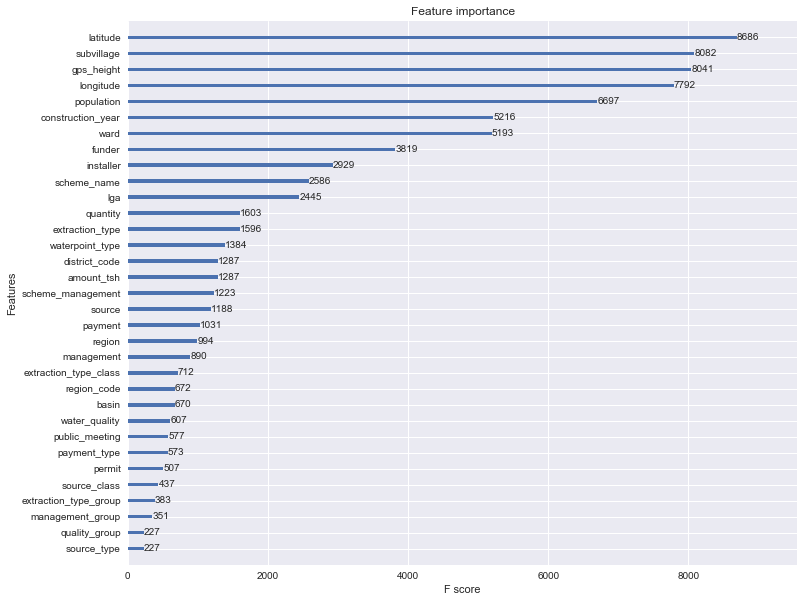

In [104]:
%matplotlib inline
my_plot_importance(xgb, (12, 10))

### Random Forest

RandomForest produces a robust result because it works well on non-linear and the categorical data. It adapts to the data structure taking into consideration of the high variance or the bias, producing better results on large datasets.

Pros:
* Does not require creation of a predictive model for each attribute with missing data in the dataset
* Correlation of the data is neglected

Cons:
* Is a very time consuming process and it can be critical in data mining where large databases are being extracted
* Choice of distance functions can be Euclidean, Manhattan etc. which is do not yield a robust result

In [105]:
#rf = RandomForestClassifier()

In [106]:
'''param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}'''

"param_grid = { \n    'n_estimators': [200, 500],\n    'max_features': ['auto', 'sqrt', 'log2'],\n    'max_depth' : [4,5,6,7,8],\n    'criterion' :['gini', 'entropy']\n}"

In [107]:
#CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
#CV_rf.fit(X_train, y_train)

In [108]:
#CV_rf.best_params_

In [109]:
rf = RandomForestClassifier(random_state=random_seed, max_features='auto', n_estimators= 500, max_depth=8, criterion='gini')

In [110]:
rf_fit = rf.fit(X_train_scaled, y_train)
rf_pred = rf_fit.predict(X_test_scaled)

In [111]:
accuracy_score(y_test,rf_pred)
# 0.7979 scaled

0.7404882154882155

In [112]:
print('Misclassified samples: %d' % (y_test != rf_pred).sum())

Misclassified samples: 3083


In [113]:
print(classification_report(y_test,rf_pred))

                         precision    recall  f1-score   support

             functional       0.69      0.96      0.80      6457
functional needs repair       0.71      0.01      0.01       851
         non functional       0.89      0.57      0.69      4572

            avg / total       0.77      0.74      0.70     11880



# Deep Learning

In [114]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_use)
y_encoded = encoder.transform(y_use)
# convert integers to dummy variables (i.e. one hot encoded)
y_ANN = np_utils.to_categorical(y_encoded)

In [115]:
pd.DataFrame(y_encoded)[0].value_counts()

0    32259
2    22824
1     4317
Name: 0, dtype: int64

In [116]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD

from keras_tqdm import TQDMNotebookCallback

In [117]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_ANN = np.array(X_use)
X_ANN = scaler.fit_transform(X_ANN)

In [118]:
features = 35
num_classes = 3

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(features,)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', input_shape=(features,)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', input_shape=(features,)))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [119]:
#optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
optimizer = 'adam'

In [120]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [121]:
history = model.fit(X_ANN, y_ANN, validation_split=0.20, epochs=100, batch_size=256,
                    verbose=0, callbacks=[TQDMNotebookCallback(leave_inner=False)])

/Users/Claudi/anaconda/lib/python3.5/site-packages/keras/callbacks.py:118: UserWarning:

Method on_batch_end() is slow compared to the batch update (0.127992). Check your callbacks.



In [122]:
print(history.history.keys())

dict_keys(['acc', 'val_loss', 'val_acc', 'loss'])


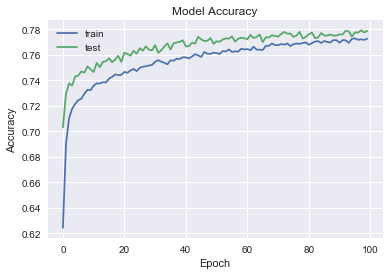

In [123]:
# summarizing historical accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [124]:
history.history['acc'][-1]

0.7725799662496907

# Final model prediction

In [125]:
X_final = pd.read_csv('test_feats.csv')

In [126]:
X_final_id = X_final.id

In [127]:
X_final = X_final.drop(['id', 'date_recorded', 'num_private', 'wpt_name', 'recorded_by'], axis=1)

In [128]:
clean(X_final)

No missing values.
Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.


In [129]:
X_final = encode_X(X_final)

In [130]:
# normalize the data - for......
X_final_scaled = scaler.transform(X_final)

In [131]:
xgb_pred = xgb_fit.predict(X_final)

/Users/Claudi/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



In [132]:
xgb_pred.shape

(14850,)

```
0 = functional
1 = functional needs repair
2 = non functional```

In [133]:
pd.DataFrame(y_encoded)[0].value_counts()

0    32259
2    22824
1     4317
Name: 0, dtype: int64

In [134]:
pd.DataFrame(y)['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [135]:
prob = model.predict(X_final_scaled) 
ANN_pred = prob.argmax(axis=-1).tolist()

In [136]:
for index, pred in enumerate(ANN_pred):
    if pred == 0:
        ANN_pred[index] = 'functional'
    elif pred == 1:
        ANN_pred[index] = 'functional needs repair'
    elif pred == 2:
        ANN_pred[index] = 'non functional'
    else:
        continue

# Submit results

Your `.csv` file that you submit would look like:

```
id,status_group
50785,functional
51630,functional
17168,functional
45559,functional
...
```

In [137]:
results = pd.DataFrame({'id': np.array(X_final_id), 'status_group': ANN_pred}, columns=['id', 'status_group'])

In [138]:
results.shape

(14850, 2)

In [139]:
results.to_csv('results_ANN1.csv', index=False)